In [1]:
from fst.io import access, read
from mrcfile.mrcmemmap import MrcMemmap
from skimage.io import imread
from numcodecs import GZip
import dask.array as da
import numpy as np
import dask
from toolz import partition_all
from tqdm import tqdm
from fst.scripts.python.consolidate_dataset import n5v_array_attrs

In [2]:
def mrc_to_dask(fname, stride):
    from fst.io import read
    from itertools import product
    from dask import delayed
    with read(fname) as mem:
        shape = mem.data.shape
        dtype = mem.data.dtype
        if mem.data.flags['C_CONTIGUOUS']:
            chunks = (stride, -1,-1)
            concat_axis = 0
        elif mem.data.flags['F_CONTIGUOUS']:
            chunks = (-1,-1, stride)
            concat_axis = len(shape) - 1
        else:
            raise ValueError('Could not infer whether array is C or F contiguous')
    template = da.zeros(shape=shape, dtype=dtype, chunks=chunks)    
    slices = da.core.slices_from_chunks(template.chunks)
    shapes = list(product(*template.chunks))
    @delayed
    def loader(sl): 
        from fst.io import read
        import numpy as np
        with read(fname) as mrc:
            result = np.array(mrc.data[sl])
        return result
    
    arr = da.concatenate([da.from_delayed(loader(sl), shape=shapes[idx], dtype=dtype) for idx,sl in enumerate(slices)], axis=concat_axis)
    return arr

In [3]:
from fst.distributed import get_cluster
cl = get_cluster(walltime="300")
cl

Client Scheduler: tcp://10.36.110.13:32603 Dashboard: http://10.36.110.13:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
from pathlib import Path
source_files = Path('/groups/hess/hesslab/HighResPaper_rawdata/').glob('*/*.mrc')
[print(p) for p in source_files]

/groups/hess/hesslab/HighResPaper_rawdata/4. Fly Fan Shaped Body[Column1-9]_Z0519-11_4x4x4nm/FB-Z0519-11 4x4x4nm.mrc
/groups/hess/hesslab/HighResPaper_rawdata/5. Fly_AccessoryCalyx_Z0519-15_4x4x4nm/SIFTalignCombo.mrc
/groups/hess/hesslab/HighResPaper_rawdata/3. HeLa3_Aubrey_17-7_17_Cell3_4x4x4nm/HeLa_Cell3_17-7_17_ 4x4x4nm.mrc
/groups/hess/hesslab/HighResPaper_rawdata/2. HeLa2_Aubrey_17-7_17_Cell2_4x4x4nm/HeLa2_Cell2 4x4x4nm.mrc
/groups/hess/hesslab/HighResPaper_rawdata/8. SUM159_WT45_Cell2_4x4x4nm/SUM159_WT45_Cell2_Cryo_20171009_4x4x4nm.mrc
/groups/hess/hesslab/HighResPaper_rawdata/7. Jurkat_Cryo_2017_FS96_Cell1_4x4x4nm/Jurkat_Cryo_2017_FS96_Area1 4x4x4nm.mrc
/groups/hess/hesslab/HighResPaper_rawdata/6. Macrophage_FS80_Cell2_4x4x4nm/Macrophage_FS80_Cell2 4x4x4nm.mrc
/groups/hess/hesslab/HighResPaper_rawdata/1. Pancreas Islet_G64-2-1-HighGlucose_4x4x4nm/G64-2-1_HighGlucose 4x4x4nm.mrc
/groups/hess/hesslab/HighResPaper_rawdata/10. HeLa_mitotic_17-7_Cell4_4x4x4nm/HeLa_mitotic_17-7_17_Cel

[None, None, None, None, None, None, None, None, None, None, None]

In [5]:
source_file = '/groups/hess/hesslab/HighResPaper_rawdata/5. Fly_AccessoryCalyx_Z0519-15_4x4x4nm/SIFTalignCombo.mrc'
exp_name = 'jrc_fly-accessory-calyx_a00'
resolution = [4.0,4.0,4.0]
array_attrs = n5v_array_attrs(dimensions=resolution, unit='nm')
with read(source_file) as mem:
    shape = mem.data.shape
    dtype = mem.data.dtype
template = da.zeros(shape, chunks=(1,-1,-1), dtype=dtype)
slices = da.core.slices_from_chunks(template.chunks)

In [6]:
def rescaler(arr, in_range):
    from skimage.exposure import rescale_intensity as rescale
    return rescale(arr.astype('int16'), in_range=in_range, out_range='uint8').astype('uint8')

def minmax(sl):
    import mrcfile.mrcmemmap as mem
    from importlib import reload
    reload(mem)
    import gc
    with mem.MrcMemmap(source_file) as f:
        arr = np.array(f.data[sl])
    gc.collect()
    return arr.min(), arr.max()

In [ ]:
%%time
n = 50
cl.cluster.scale(n)
cl.wait_for_workers(n)
result = np.array(cl.gather(cl.map(minmax, slices))).astype('int')
clims = result.min(), result.max()
cl.cluster.scale(0)

In [23]:
chunks = (128,128,128)
dest = f'/groups/cosem/cosem/bennettd/{exp_name}/{exp_name}.n5/volumes/aligned'
output_dtype = 'uint8'
output = access(dest, mode='a', 
                shape=shape, 
                chunks=chunks, 
                dtype=output_dtype, 
                compressor=GZip(-1))

output.attrs.put(array_attrs)
slices = da.core.slices_from_chunks(da.zeros(shape, chunks=chunks).chunks)
assert read(dest).chunks == chunks

In [24]:
def saver(sl): 
    if sl is None:
        return True
    try:
        sink = access(dest, mode='a')
        source = MrcMemmap(source_file)    
        sink[sl] = rescaler(np.array(source.data[sl]), in_range=clims)
        result = True
    except:
        print('Something went wrong')
        result = False
    return result


In [25]:
psize = 20000
slices_partitioned = list(partition_all(psize, slices))

In [28]:
results = []
cl.cluster.scale(80)
for batch in tqdm(slices_partitioned):
    results.append(cl.gather(cl.map(saver, batch)))
cl.cluster.scale(0)

100%|██████████| 45/45 [2:18:29<00:00, 184.65s/it]  


In [41]:
arr = da.from_array(read('/groups/cosem/cosem/data/jrc_ctl-id8_a00/jrc_ctl-id8_a00.n5/volumes/aligned'))
sample = arr[:,arr.shape[1]//3,:].compute(scheduler='processes')

In [43]:
sample.dtype

dtype('int8')

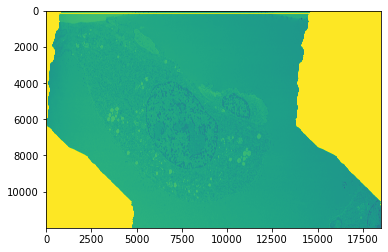

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(sample)